In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from scipy import signal
# from scipy.io import wavfile

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn

from common_audio import *
from audio_dataset import *

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)



cpu


In [2]:
sr = 10000
duration = 4.9
voice_ds = AudioDataSet('datasets/LibriSpeech/LibriSpeech/dev-clean', sr=sr, duration=duration)
# ads = AudioDataSet('datasets/urban/UrbanSound8K/audio')


In [3]:
def generate_tone(sr, duration, freq, amplitude=None):
    if amplitude is None:
        amplitude = np.ones_like(freq)
    freq, amplitude = freq[:, None], amplitude[:, None]
    length = int(sr*duration)
    full = np.tile(np.arange(length), (freq.shape[1], 1))
    y = amplitude * np.sin(2*np.pi/sr * freq * full)
    return y

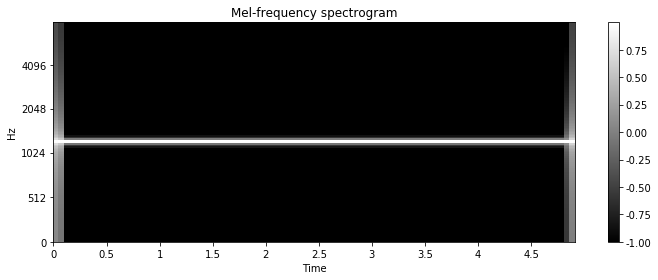

In [36]:


tone_y = generate_tones(sr, duration, np.array([1024, 2048]), np.array([1, 2]))
play_audio(tone_y[0], sr)

show_spectrogram(audio_to_spectrogram(tone_y[0], sr), sr)

# Manual Method
Seperating the frequency manually from spectrogram

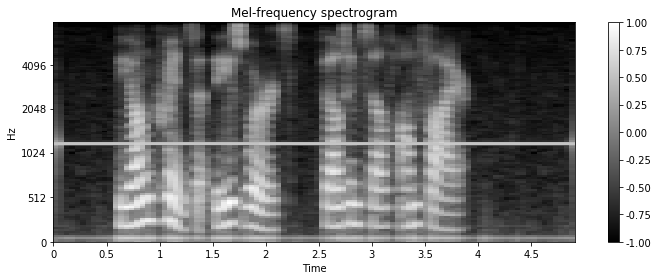

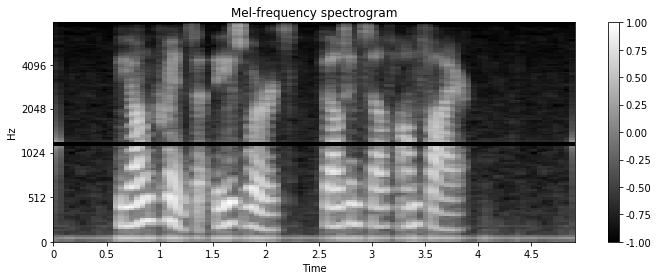

In [125]:
y_voice = voice_ds.load([1])[0]
y_tone = generate_tones(sr, duration, np.array([1000]), np.array([0.01]))[0]

y = y_voice + y_tone
play_audio(y, sr)
spectrogram = audio_to_spectrogram(y, sr)

show_spectrogram(spectrogram, sr)
plt.show()
play_audio(spectrogram_to_audio(spectrogram, sr), sr)

spectrogram[48:51, :] = -1.

show_spectrogram(spectrogram, sr)
plt.show()
play_audio(spectrogram_to_audio(spectrogram, sr), sr)


# Naive Method

Make a neural network to just take out the tone

In [72]:
# create test set
voice_ds.reset_next()
X_test_voice = voice_ds.load_next(200, pbar=tqdm())
X_test_tone = generate_tones(sr, duration, np.linspace(500, 2000, 200))

X_test = X_test_voice + X_test_tone
Y_test = X_test_voice

X_test = audios_to_spectrograms(X_test, sr, normalize=True)
Y_test = audios_to_spectrograms(Y_test, sr, normalize=True)


In [114]:
class VoiceIsolaterNet(nn.Module):
    def __init__(self):
        super(VoiceIsolaterNet, self).__init__()
#         self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        
        self.linear1 = nn.Linear(786432, 100)
        self.linear2 = nn.Linear(100, 786432)
        
        self.convt1 = nn.ConvTranspose2d(64, 16, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(16, 4, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(4, 1, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
#         x = self.maxpool(x)
#         x = torch.tanh(x)

        x = self.conv3(x)
#         x = self.maxpool(x)
        x = torch.tanh(x)
        
        y = x.view(x.shape[0], -1)
        
        y = self.linear1(y)
        y = torch.tanh(y)
        
        y = self.linear2(y)
        y = torch.tanh(y)
        
        y = y.view(x.shape)
        
        x = x + y

        x = self.convt1(x)
        x = torch.tanh(x)
        x = self.convt2(x)
        x = torch.tanh(x)
        x = self.convt3(x)
        x = torch.tanh(x)
        
        return x
    
vin = VoiceIsolaterNet().to(device, dtype)

Mean squared error:  0.21184010320061689


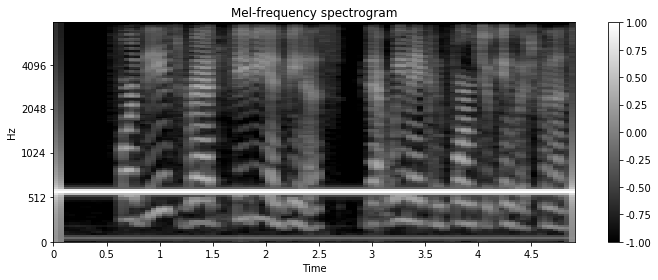

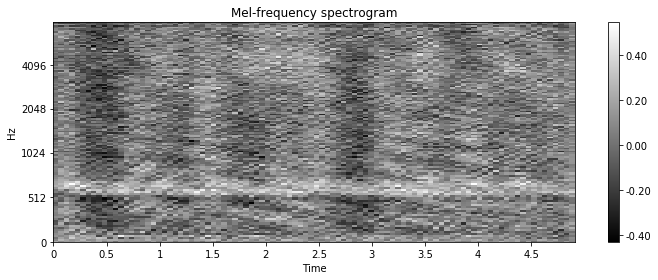

In [115]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vin.forward(tin).detach().cpu().numpy()[:, 0, :, :]

print('Mean squared error: ', ((Y_test - tout)**2).mean())

show_spectrogram(X_test[0], sr)
plt.show()
show_spectrogram(tout[0], sr)
plt.show()

0.021105845
0.019923825
0.019940807
0.021052431
0.01926582
0.019482922
0.019578027
0.018469905
0.018051501
0.017386133
0.018039338
0.018171946
0.017788958
0.017205896
0.016714571
0.015865084
0.016448593
0.015883442
0.015804483
0.015375114
0.016226096
0.016189706
0.015008677
0.013915854
0.015103811

CPU times: user 1min 53s, sys: 23.9 s, total: 2min 17s
Wall time: 1min 50s


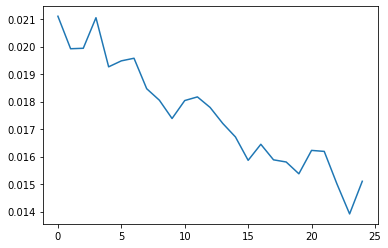

In [120]:
%%time
crit = nn.MSELoss()
losses = []
batch_num = 10
for epoch in tqdm(range(25)):
    X_batch_voice = voice_ds.load_next(batch_num, pbar=None)
    X_batch_tone = generate_tones(sr, duration, np.linspace(500, 2000, batch_num))

    X_batch = X_batch_voice + X_batch_tone
    Y_batch = X_batch_voice

    X_batch = audios_to_spectrograms(X_batch, sr, normalize=True)
    Y_batch = audios_to_spectrograms(Y_batch, sr, normalize=True)    
    
    X_batch = torch.from_numpy(X_batch).to(device,dtype)[:, None, :, :]
    Y_batch = torch.from_numpy(Y_batch).to(device,dtype)[:, :, :]
    
    vin.opt.zero_grad()
    Y = vin.forward(X_batch)[:, 0, :, :]
    loss = crit(Y, X_batch[:, 0, :, :])
    
    loss.backward()
    
    vin.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

Mean squared error:  0.17263227058084116


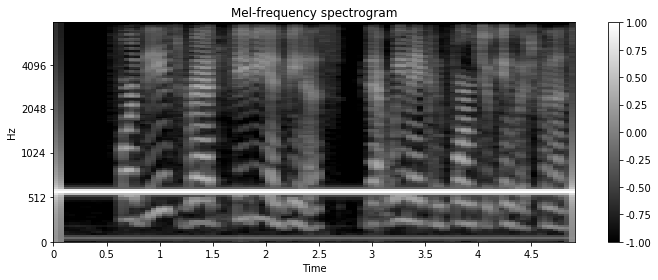

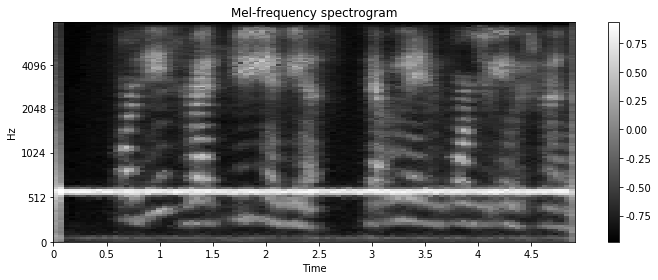

In [121]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vin.forward(tin).detach().cpu().numpy()[:, 0, :, :]

print('Mean squared error: ', ((Y_test - tout)**2).mean())

show_spectrogram(X_test[0], sr)
plt.show()
show_spectrogram(tout[0], sr)
plt.show()

In [123]:
play_audio(spectrogram_to_audio(tout[0], sr), sr)

# Our Method

add details...

In [4]:
class VoiceRecogNet(nn.Module):
    def __init__(self):
        super(VoiceRecogNet, self).__init__()
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        
        x = self.linear3(x)
        x = torch.sigmoid(x)
        
        return x
    
vrn = VoiceRecogNet().to(device)

In [5]:
# create test set
voice_ds.reset_next()
X_test_voice = voice_ds.load_next(100, pbar=tqdm())
X_test_tone = generate_tones(sr, duration, np.linspace(500, 2000, 100))

X_test = np.concatenate((X_test_voice, X_test_tone), axis=0)
Y_test = np.concatenate((np.ones(X_test_voice.shape[0]), np.zeros(X_test_tone.shape[0])), axis=0)

X_test = audios_to_spectrograms(X_test, sr, normalize=True)


In [6]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  0.5


0.69328344
0.625149
0.50964385
0.3580653
0.18374917
0.10838596
0.045182668
0.015382772
0.0047557587
0.002027946
0.00070683996
0.000681378
5.9180642e-05
2.2062975e-05
0.00017370297
3.6984843e-06
6.565458e-05
7.722303e-06
2.1253485e-05
4.0233226e-07
2.3841886e-07
6.311936e-05
2.9802323e-09
3.278266e-07
0.0
2.3841864e-08
0.0
0.0
0.0
0.0
0.0
2.3841864e-08
9.5367525e-08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

CPU times: user 1min 11s, sys: 4.57 s, total: 1min 15s
Wall time: 51.3 s


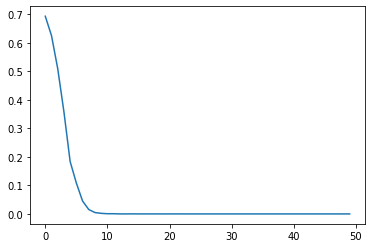

In [7]:
%%time
crit = nn.BCELoss()
losses = []
batch_num = 10
for epoch in tqdm(range(50)):
    X_batch_voice = voice_ds.load_next(batch_num, pbar=None)
    X_batch_tone = generate_tones(sr, duration, np.linspace(500, 2000, batch_num))

    X_batch = np.concatenate((X_batch_voice, X_batch_tone), axis=0)
    Y_batch = np.concatenate((np.ones(X_batch_voice.shape[0]), np.zeros(X_batch_tone.shape[0])), axis=0)

    X_batch = audios_to_spectrograms(X_batch, sr, normalize=True)
    X_batch = torch.from_numpy(X_batch).to(device,dtype)[:,None, :, :]
    Y_batch = torch.from_numpy(Y_batch).to(device,dtype)

    
    vrn.opt.zero_grad()
    Y = vrn.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vrn.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

In [8]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  1.0
